In [678]:
import warnings
import gc

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import SparsePCA, KernelPCA, PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from bayes_opt import BayesianOptimization

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [10, 10]

warnings.simplefilter('ignore')

In [120]:
raw_train = pd.read_csv('./data/train.csv')

In [121]:
def rmsle(y, y_pred, epislon=1e-20):
    log_error = np.log(y + epislon) - np.log(y_pred + epislon)
    return np.sqrt(np.mean(np.square(log_error[~na_mask]), axis=0))

rmsle_score = make_scorer(rmsle, greater_is_better=False)

In [666]:
def rmse(y, y_pred):
    error = y - y_pred
    return np.sqrt(np.mean(np.square(error), axis=0))

rmse_score = make_scorer(rmse, greater_is_better=False)

In [123]:
def drop_invariant(frame):
    
    drop_variables = []
    categorical = frame.select_dtypes(['object', 'category'])
    continuous = frame.select_dtypes(['number'])
    
    mask = categorical.nunique(axis=0) == 1
    drop_variables.extend(categorical.columns[mask].tolist())
    
    mask = continuous.std(axis=0) == 0
    drop_variables.extend(continuous.columns[mask].tolist())
    
    print('{0} variables dropped.'.format(len(drop_variables)))
    return frame.drop(drop_variables, axis=1)

In [386]:
def compute_feature(frame, methods=None):
    m, n = frame.shape
    methods = methods or ['min', 'max', 'std', 'mean', 'median', 'skew', 'kurtosis']
    statistic_frames = []
    for method in methods:
        z = getattr(frame, method)(axis=0).to_frame().transpose()
        data = pd.concat(m * [z], axis=0, ignore_index=True)._data
        statistic_frame = frame.copy(deep=False)
        statistic_frame._data = data
        statistic_frame.columns = ['{0}_{1}'.format(i, method) for i in frame.columns]
        statistic_frame.index = frame.index
        statistic_frames.append(statistic_frame)
    return pd.concat([frame] + statistic_frames, axis=1).sort_index(axis=1)

In [317]:
def sample_feature_importance(meta_estimator):
    sampling_stats = np.vstack([t.feature_importances_
                                for t in meta_estimator.estimators_])

    sample_mean = sampling_stats.mean(axis=0)
    descending_mask = np.argsort(sample_mean)[::-1]

    return sampling_stats, descending_mask

In [289]:
raw_train_1 = drop_invariant(raw_train)

256 variables dropped.


In [422]:
X = raw_train_1[raw_train_1.columns.difference(['target', 'ID'])]
y = raw_train_1['target']

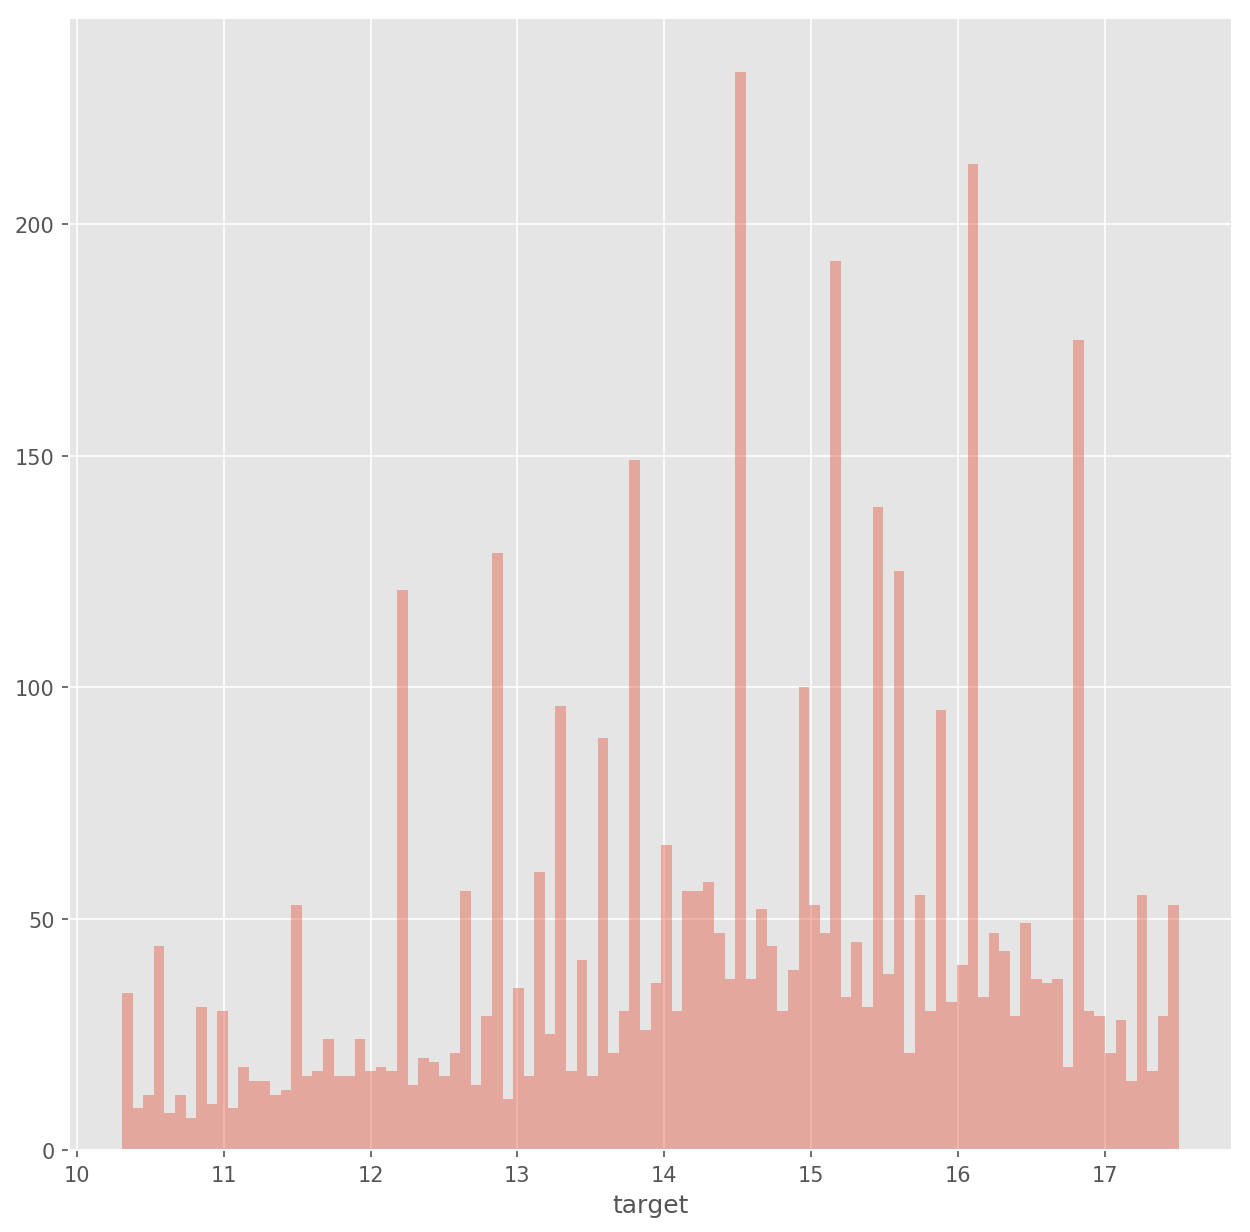

In [424]:
sns.distplot(np.log(y), norm_hist=False, kde=False, bins=100)

In [425]:
feat_select = RandomForestRegressor(30)
feat_select.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [426]:
sample_means, feat_indice = sample_feature_importance(feat_select)

In [427]:
sorted_feat_importance = sample_means[:, feat_indice].mean(axis=0)

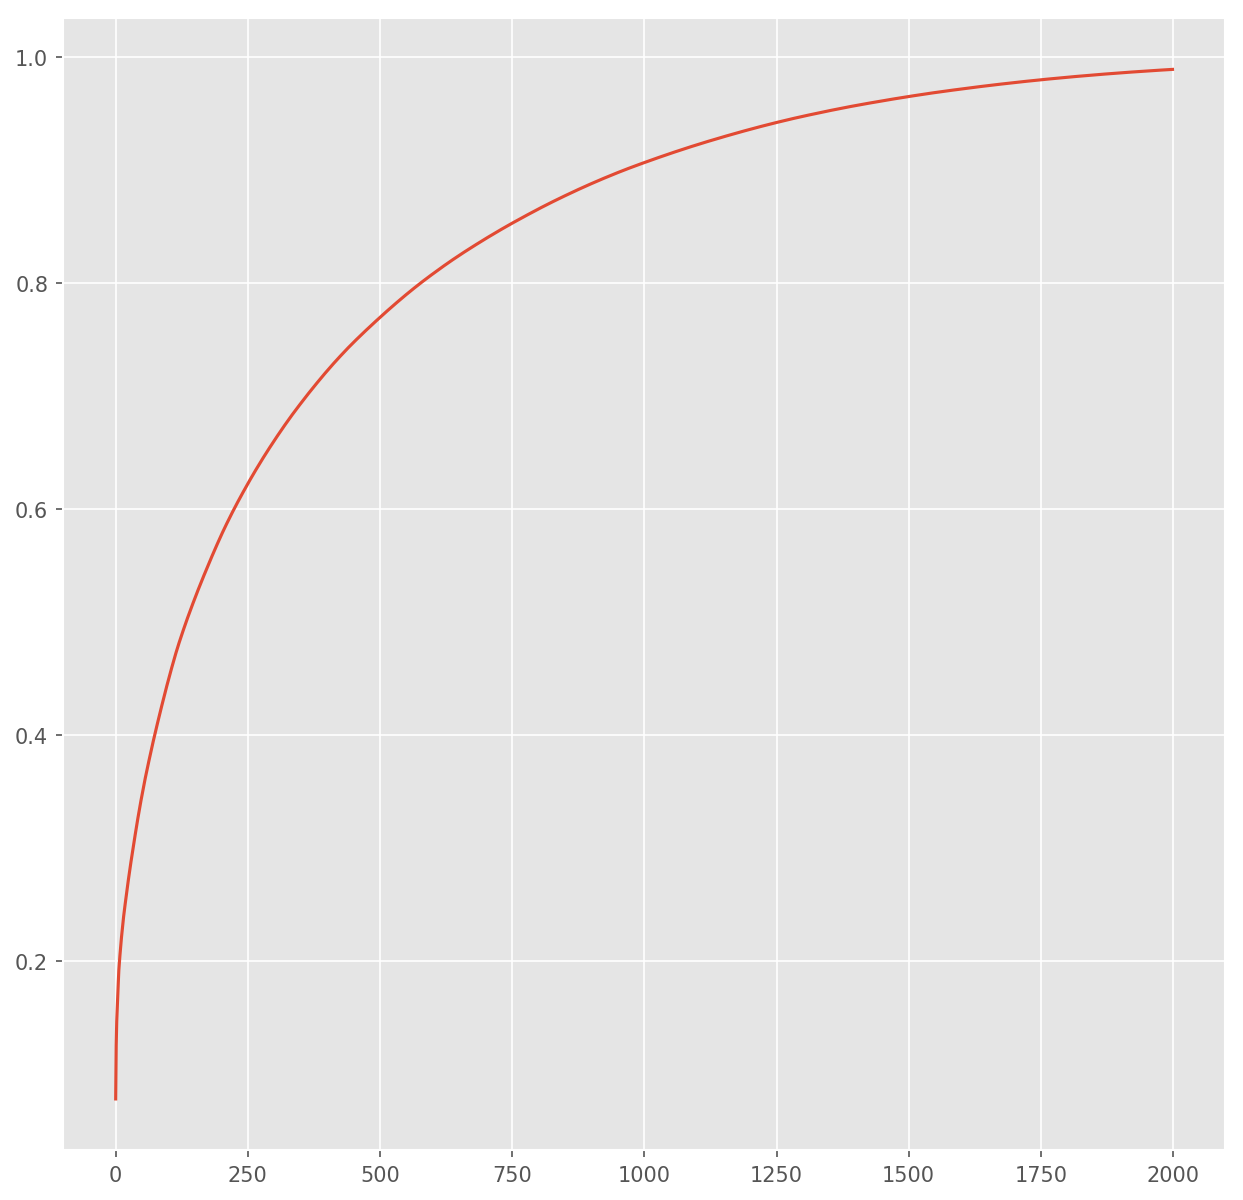

In [428]:
sns.lineplot(data=np.cumsum(sorted_feat_importance)[:2000])

In [429]:
selected_features = [X.columns[f] for f in feat_indice]

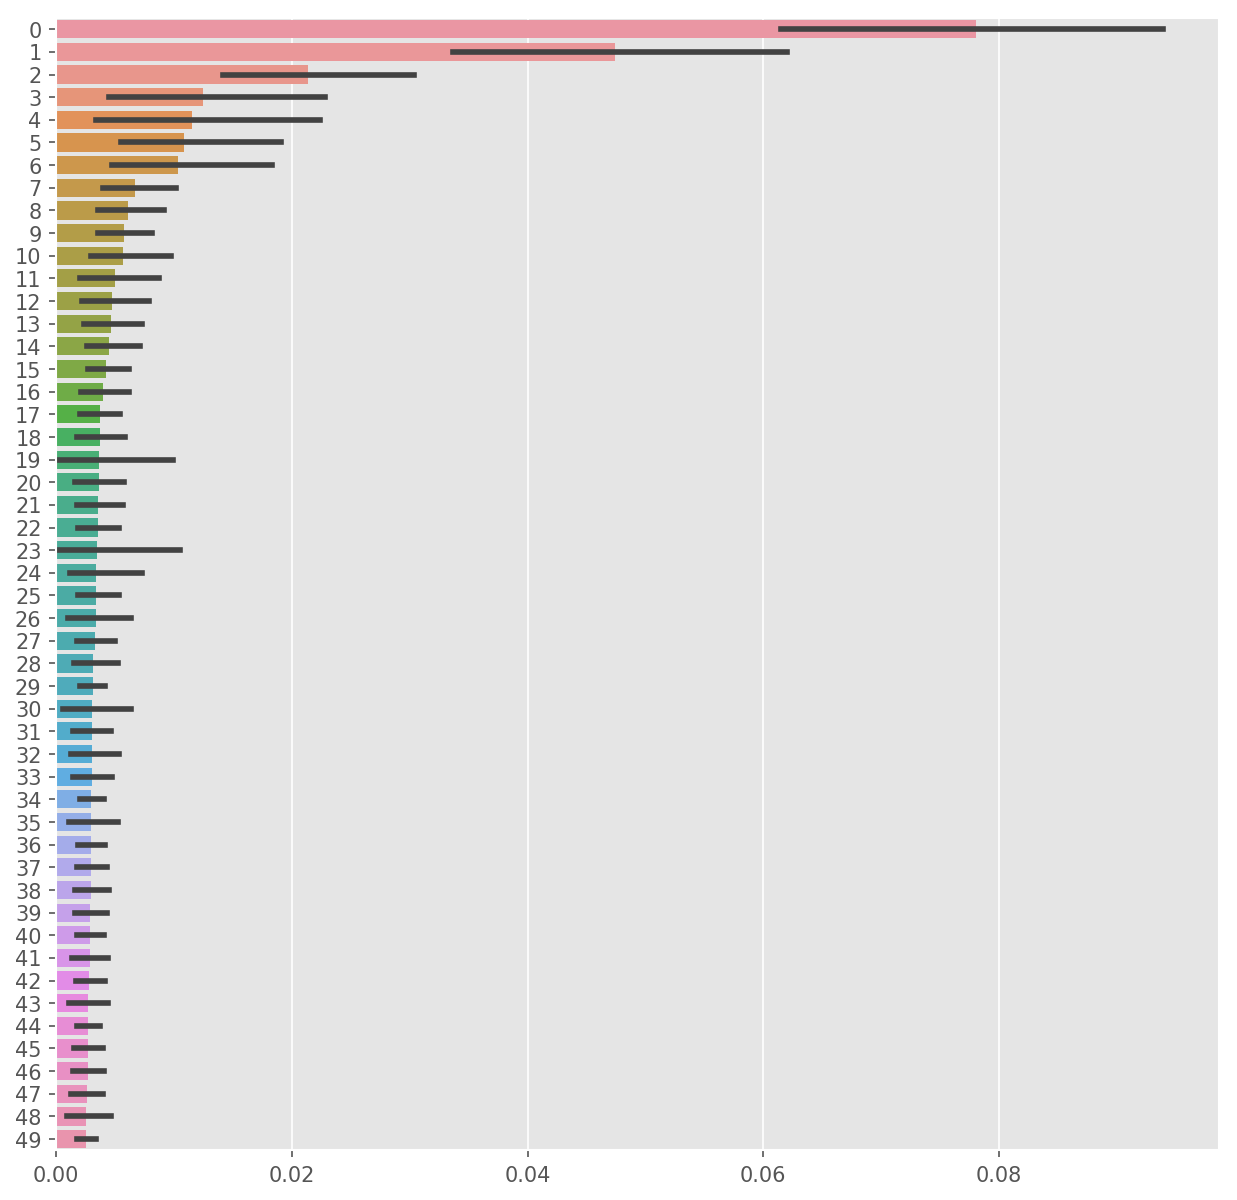

In [431]:
sns.barplot(data=sample_means[:, feat_indice[:50]], ci=95, orient='h')

In [708]:
selected_features = [
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a',
    '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
    '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98'
]

In [709]:
X_reduced = X[selected_features]
X_derived = compute_feature(X_reduced.replace(0, np.nan), ['std', 'mean', 'skew', 'kurtosis', 'sum', 'count'])

In [715]:
X_reduced

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,...,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
0,1866666.66,12066666.66,700000.00,600000.00,900000.0,4100000.00,0.00,0.00,0.00,0.00,...,400000.00,0.00,0.00,5000000.00,400000.00,0.00,0.00,0.00,0.00,0.00
1,0.00,2850000.00,2225000.00,1800000.00,800000.0,0.00,0.00,3300000.00,2200000.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.0,0.00,0.00,6000000.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2000000.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,37662000.0,0.00,4000000.00,6700000.00,2000000.00,5400000.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8000000.00,0.00,0.00
5,0.00,0.00,2800000.00,17000000.00,0.0,556000.00,0.00,0.00,17020000.00,17020000.00,...,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00,17020000.00
6,10000.00,4000.00,0.00,30000.00,0.0,0.00,0.00,4000.00,0.00,2000.00,...,0.00,6000.00,0.00,14000.00,0.00,22000.00,6000.00,15000.00,360000.00,18000.00
7,0.00,0.00,0.00,65000000.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,3333333.34,3925333.34,4000000.00,0.00,0.0,0.00,58000.00,58000.00,58000.00,58000.00,...,58000.00,58000.00,58000.00,58000.00,58000.00,58000.00,58000.00,58000.00,58000.00,58000.00
9,7500000.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,1100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [710]:
def crossval(callable, *cv_params, **model_params):
    
    model_params = _format_param(callable(), model_params)
    estimator = callable(**model_params)

    return cross_val_score(estimator, *cv_params).mean()

In [711]:
def _format_param(estimator, params):

    _default = estimator.get_params()

    for param in params:
        params[param] = type(_default[param])(params[param])

    return params

In [712]:
lgb_search_bounds = {
     'colsample_bytree': [0.1, 1.0],
     'learning_rate': [0.01, 0.1],
     'num_leaves': [25, 70],
     'subsample': [0.1, 1.0],
     'reg_alpha': [0, 10],
     'reg_lambda': [0, 10],
}

In [713]:
cv = KFold(5, shuffle=True, random_state=99)

In [704]:
cv_params = [X_derived, np.log(y), None, rmse_score, cv]

In [705]:
def f(static_params=cv_params, **params):
    return crossval(LGBMRegressor, *static_params, **params)

In [706]:
lgbopt = BayesianOptimization(f, lgb_search_bounds)

In [707]:
lgbopt.maximize(init_points=5, n_iter=500)

Initialization
------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
    1 | 00m07s |   -1.45593 |             0.9150 |          0.0282 |      49.0393 |      9.8153 |       1.8384 |      0.8279 | 
    2 | 00m08s |   -1.45833 |             0.7638 |          0.0750 |      59.5969 |      4.4921 |       1.0848 |      0.4333 | 
    3 | 00m04s |   -1.46835 |             0.1529 |          0.0277 |      39.8748 |      2.5758 |       5.4003 |      0.9393 | 
    4 | 00m04s |   -1.44912 |             0.8560 |          0.0459 |      33.5066 |      6.4122 |       7.3214 |      0.5012 | 
    5 | 00m06s |   -1.45085 |             0.4276 |          0.0869 |      61.7157 |      5.4405 |       6.5410 |      0.9272 | 
Bayesian Optimization
--------------------------------------------------------------------

KeyboardInterrupt: 

In [ ]:
opt_lgb_params = _format_param(LGBMRegressor(), lgbopt.res['max']['max_params'])

In [ ]:
lgb = LGBMRegressor(**opt_lgb_params)

In [ ]:
cross_val_score(lgb, X_derived, np.log(y), scoring=rmse_score, cv=cv).mean()

In [ ]:
class StackedModels(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        self._estimators = estimators
        
    def fit(self, X, y, *args, **kwargs):
        for estimator in self._estimators:
            estimator.fit(X, y, *args, **kwargs)
    
    def predict(self, X, *args, **kwargs):
        stacked_pred = [estimator.predict(X, *args, **kwargs)
                        for estimator in self._estimators]
        return np.array(stacked_pred).T

In [ ]:
raw_test = pd.read_csv('./data/test.csv')

In [ ]:
X_test_reduced = raw_test[selected_features]
X_test_derived = compute_feature(X_test_reduced.replace(0, np.nan), ['std', 'mean', 'skew', 'kurtosis', 'sum', 'count'])

In [ ]:
y_pred = []
lgb = LGBMRegressor(**opt_lgb_params)
lgb.set_params(n_estimators=10000, learning_rate=5e-2)
for train_index, valid_index in cv.split(X_derived):
    X_train, y_train = X_derived.loc[train_index], np.log(y)[train_index]
    X_valid, y_valid = X_derived.loc[valid_index], np.log(y)[valid_index]
    lgb.fit(X_train, y_train,
            early_stopping_rounds=500,
            eval_set=(X_valid, y_valid),
            eval_metric='rmse',
            verbose=False)
    score = rmse(lgb.predict(X_valid), y_valid)
    print("validation score rmsle: {0:.4f}".format(score))
    y_pred.append(np.exp(lgb.predict(X_test_derived)))
y_pred = np.mean(y_pred, axis=0)

In [ ]:
sub = pd.concat([raw_test['ID'].astype(object), pd.Series(y_pred, name='target')], axis=1)

In [ ]:
sub.to_csv('ming_submission.csv', index=False)